# Project 2: Ames Housing Data - EDA

## Problem Statement:

**According to the Ames, Iowa housing data, which regression model can most accurately predict a house's price? As a result, why should millenials choose to live in Ames based on the most important housing features determined by the optimal regression model?** 

[The Ames Iowa Housing Data](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) contains 81 variables that were used in computing assessed values for individual residential properties sold from 2006 to 2010. I will be using various regression models, such as Linear Regression, LassoCV, and RidgeCV, to determine which model most accurately fits the data by comparing RMSE and $R^2$ scores.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
from numpy.polynomial.polynomial import polyfit
from scipy import stats
import statsmodels.api as sm
import string

np.random.seed(3_0_0)

DO = '#7D1B7E'
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
train_df = pd.read_csv('../datasets/train_clean.csv', keep_default_na=False)

In [3]:
# Double checking that the dataframe has no nulls:
train_df.isnull().sum().sum()

0

# Data Exploratory Analysis:

Since the dataset is now cleaned up, I am going to explore how each predictor variable is related to the target variable, Salesprice. Furthermore, I will make note of any potentially collinear predictors and potentially useless variables.

In [4]:
train_df.dtypes.value_counts()

object     42
int64      25
float64    10
dtype: int64

First, I am going to explore how each integer and float variable is related to the SalesPrice. 

Ordinal variables, such as 'Overall Quality' and 'Overall Condition', are casted as integers and have values on a scale from 1 to 10. One being 'very poor' and 10 being 'very excellent'. 

Continuous variables, such as 'General Living Area' and '1st Floor square feet', are casted as floats and are usually associated with the square footage of a house.

## Numerical Predictor Variables

In [5]:
numerical_cols = list(train_df.describe().columns)

I want to explore the correlation between the Sale Price and both of the dataset's integer and float predictor variables. The absolute value of the correlation coefficients will be taken, because I want to see which variables have the strongest or weakest linear relationship with Sale Price.

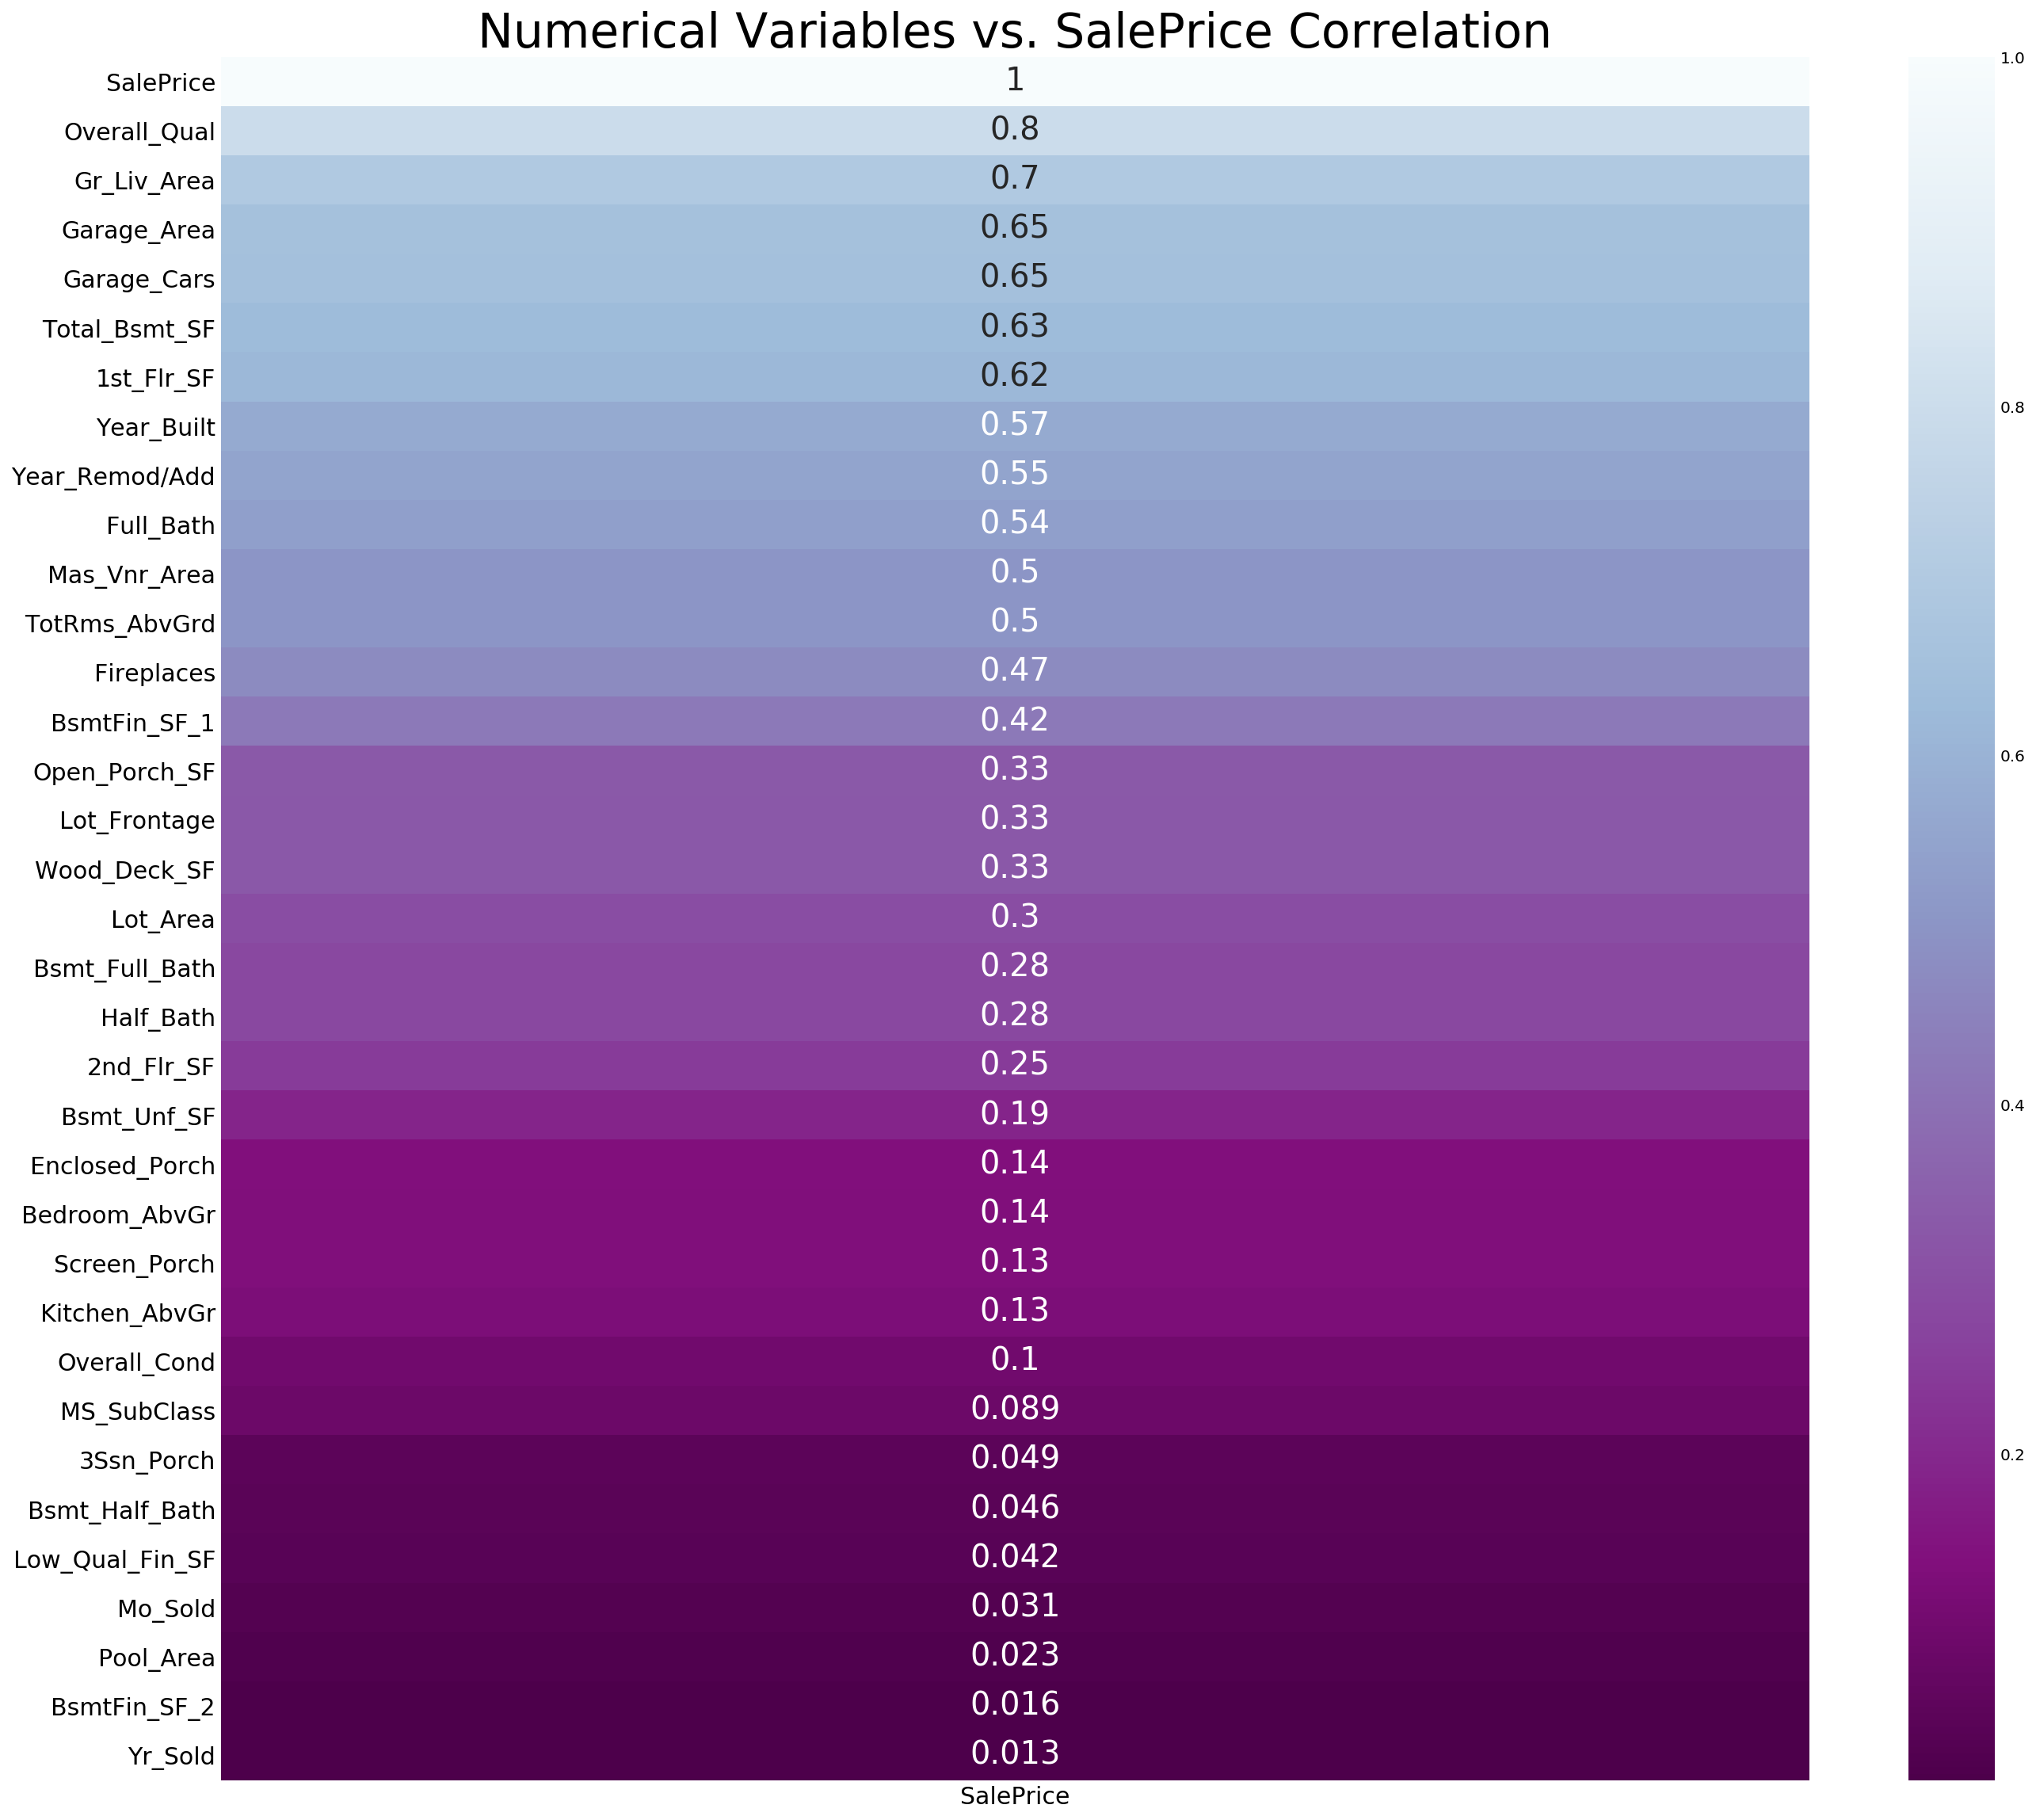

In [6]:
plt.figure(figsize=(20,20))

ax = sns.heatmap(abs(train_df.corr()).sort_values('SalePrice', ascending = False)[['SalePrice']], annot=True, annot_kws={"size":20}, cmap = 'BuPu_r');

ax.set_title('Numerical Variables vs. SalePrice Correlation', fontsize=30)
ax.tick_params(axis='x', labelsize=15, labelrotation=0)
ax.tick_params(axis='y', labelsize=15, labelrotation=0)

plt.savefig('../plots/heatmap.png')

Predictor variables that have a correlation of less than 0.1 are:

In [7]:
weak_corr_df = (abs(train_df.corr())[['SalePrice']]<0.1).reset_index()
[name for name in weak_corr_df[weak_corr_df['SalePrice'] == True]['index']]

['MS_SubClass',
 'BsmtFin_SF_2',
 'Low_Qual_Fin_SF',
 'Bsmt_Half_Bath',
 '3Ssn_Porch',
 'Pool_Area',
 'Mo_Sold',
 'Yr_Sold']

#### Observations:

**Weak Correlation**
- There are 10 numerical variables that have a correlation coefficient less than 0.1:
    - `'MS_SubClass'`, `'Overall_Cond'`, `'BsmtFin_SF_2'`, `'Low_Qual_Fin_SF'`, `'Bsmt_Half_Bath'`, `'3Ssn_Porch'`, `'Pool_Area'`, `'Misc_Val'`, `'Mo_Sold'`, `'Yr_Sold'`


- The discrepancy between `Overall_Qual` and `Overall_Cond` is surprising to me. `Overall_Qual` rates the overall material and finish of the house whereas `Overall_Cond` rates the overall condition of the house. I would have expected the variables to share a similar correlation coefficient. 


- I expect there to be some collinearity among `Gr_Liv_Area`, `1st_Flr_SF`, and `2nd_Flr_SF`, because all 3 variables refer to the square footage above grade.

Some numerical variables are discrete and others are continuous. I am going to split the numerical columns for better scatter plot visualizations.

In [8]:
discrete_cols = [var for var in numerical_cols if train_df[var].value_counts().count() < 20]
cont_cols = [var for var in numerical_cols if (var not in discrete_cols) and (var != 'SalePrice')]

In [9]:
def subplot_scatter(dataframe, list_of_columns, y_val, figsize_height = 80):
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
        fig, ax = plt.subplots(figsize=(20,figsize_height),nrows=nrows, ncols=2) # You'll want to specify your figsize
        ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
        for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
            ax[i].scatter(dataframe[column],dataframe[y_val],color= DO )
            ax[i].set_title(f'{list_of_columns[i]} vs. {y_val}', fontsize = 23)
            ax[i].set_ylabel(y_val, fontsize = 18)
            ax[i].set_xlabel(list_of_columns[i], fontsize = 18)
            ax[i].tick_params(axis='x',labelsize=18)
            ax[i].tick_params(axis='y',labelsize=18)

## Discrete Numerical Predictor Variables

The following scatterplots are for ordinal numerical variables plotted against the SalePrice.

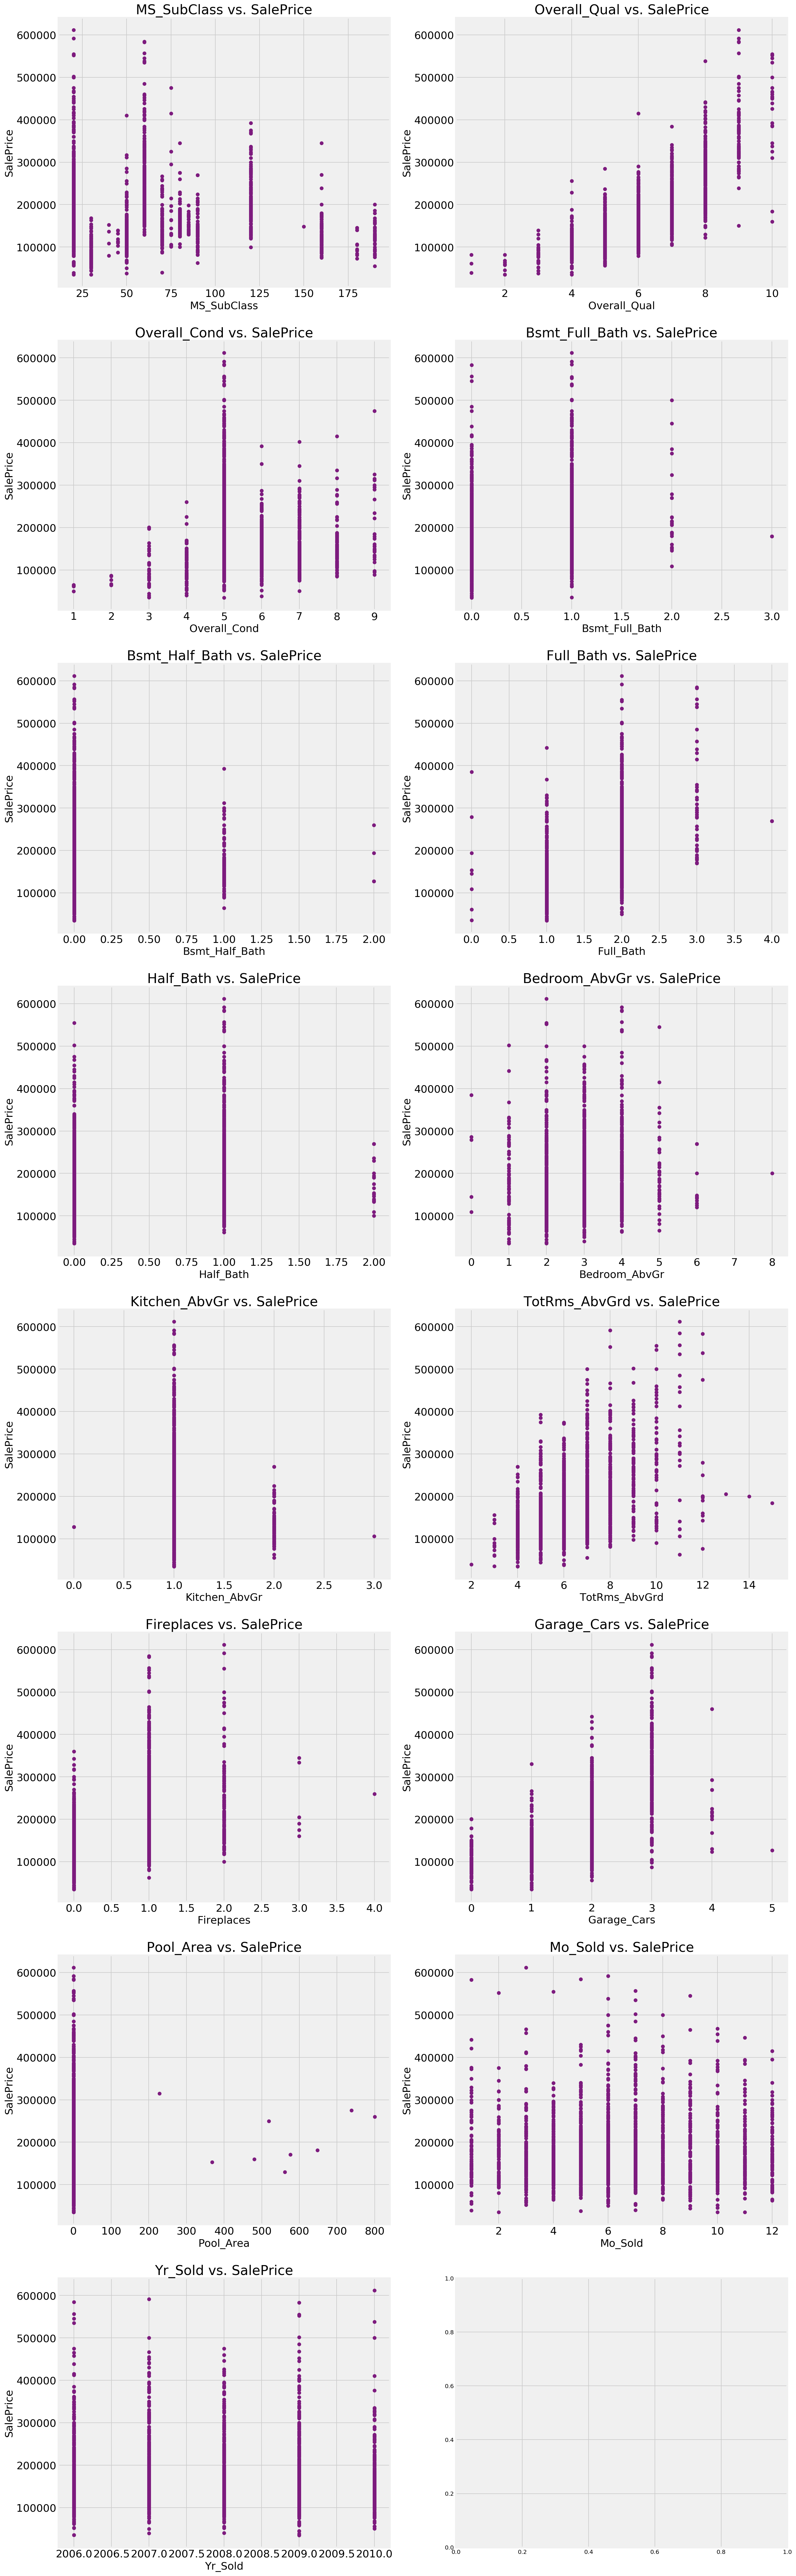

In [10]:
subplot_scatter(train_df, discrete_cols, 'SalePrice')

### Observations:


**MS_SubClass** 
- Does not seem to have a correlation with the `SalePrice`. This may be due to the fact that the numerical values actually stand for a meaning, for example, 020 stands for 1-STORY 1946 & NEWER ALL STYLES. I will replace the numerical codes with their string values.

**Overall_Qual**
- The overall quality appears to have a strong correlation with the `SalesPrice`, though the range of the `SalePrice` per overall quality value has quite a large spread

**Overall_Cond**
- The overall condition does not seem to have a strong correlation with `SalePrice`. Most houses have a condition of 5. 

**Baths**
- `Bsmt_Full_Bath`, `Bsmt_Half_Bath`, `Full_Bath`, `Half_Bath` all do not seem to have a strong correlation with SalePrice. It might make sense to combine the half bath columns together and the full bath columns together to indicate how many total half bathrooms and total full bathrooms a house has.

**Rooms Above Ground**
- The Bedroom above ground variable (`Bedroom_AbvGr`) may already be included in the total rooms above ground variable (`TotRms_AbvGrd`). Whereas `Bedroom_AbvGr` does not have a strong correlation with `SalePrice`, `TotRms_AbvGrd` does.

**Kitchen Above Ground**
- Most houses have either 1 or 2 kitchens above ground, and there does not seem to be a strong correlation with `SalePrice`.

**Fire Places**
- Most houses have either 0,1, or 2 fireplaces, and there does not seem to be a strong correlation with `SalePrice`.

**Pool Area**
- Almost all homes have 0 pools, and there is no correlation with `SalePrice`.

**Date Sold**
- Both the month and year sold variables do not seem to have any bearing on the `SalePrice`.

**Changing MS_SubClass into an object variable**

MS_SubClass' values are codes for string values that identify the type of dwelling involved in the sale.

| Code | Value |
| --- | --- |
| 20  | 1-STORY 1946 & NEWER ALL STYLES |
| 30  | 1-STORY 1945 & OLDER |
| 40  | 1-STORY W/FINISHED ATTIC ALL AGES |
| 45  | 1-1/2 STORY - UNFINISHED ALL AGES |
| 50  | 1-1/2 STORY FINISHED ALL AGES |
| 60  | 2-STORY 1946 & NEWER |
| 70  | 2-STORY 1945 & OLDER |
| 75  | 2-1/2 STORY ALL AGES |
| 80  | SPLIT OR MULTI-LEVEL |
| 85  | SPLIT FOYER |
| 90  | DUPLEX - ALL STYLES AND AGES |
| 120 | 1-STORY PUD (Planned Unit Development) - 1946 & NEWER |
| 150 | 1-1/2 STORY PUD - ALL AGES |
| 160 | 2-STORY PUD - 1946 & NEWER |
| 180 | PUD - MULTILEVEL - INCL SPLIT LEV/FOYER |
| 190 | 2 FAMILY CONVERSION - ALL STYLES AND AGES |

For scatterplot purposes, I am not going to use the description as the values because it is too long. Instead I will cast the `MS_SubClass` as an object variable because the variable displays categorical data. If any of the values show up in the top 10 beta coefficients, I will change the description again for readability purposes.

In [11]:
MS_SubClass_dict = {key:value for key,value in zip(sorted(train_df['MS_SubClass'].unique()),string.ascii_lowercase)}
MS_SubClass_dict

{20: 'a',
 30: 'b',
 40: 'c',
 45: 'd',
 50: 'e',
 60: 'f',
 70: 'g',
 75: 'h',
 80: 'i',
 85: 'j',
 90: 'k',
 120: 'l',
 150: 'm',
 160: 'n',
 180: 'o',
 190: 'p'}

In [12]:
train_df['MS_SubClass'] = train_df['MS_SubClass'].map(MS_SubClass_dict);

In [13]:
train_df['MS_SubClass'] = train_df['MS_SubClass'].astype('object');

# Removing MS_SubClass from discrete_cols
discrete_cols.remove('MS_SubClass')
numerical_cols.remove('MS_SubClass')

## Continuous Numerical Predictor Variables

The following scatterplots are for non-ordinal numerical variables plotted against the `SalePrice`.

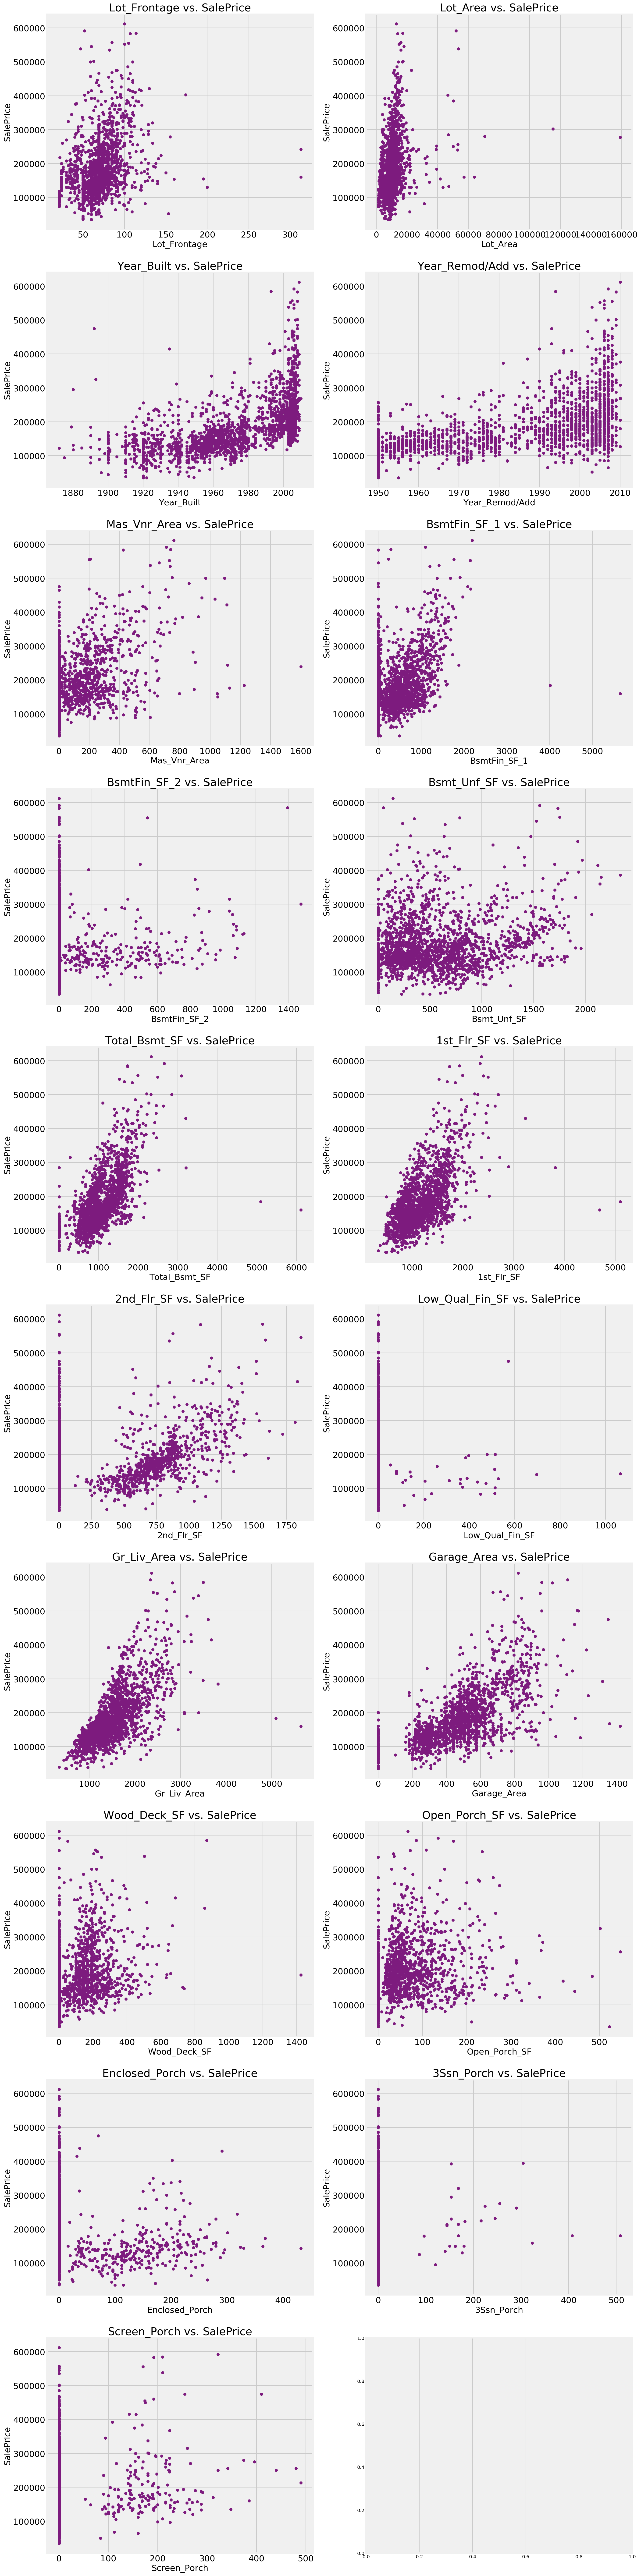

In [14]:
subplot_scatter(train_df, cont_cols, 'SalePrice', figsize_height = 100)

### Observations:


**Strong Correlation with SalePrice**
- The following variables appear to have a strong correlation with SalePrice:
    - `Year_Built`, `Year_Remod/Add`, `Mas_Vnr_Area`, `BsmtFin_SF_1`, `Total_Bsmt_SF`, `1st_Flr_SF`, `2nd_Flr_SF`, `Gr_Liv_Area`, `Garage_Area`
    - The year built and year remodeled variables have high correlation to sales price because newer houses are appraised better.
    - The square footage variables, such as the finished basement, total basement, first and second floor, general living area, and garage area, make sense due to the fact that larger houses are priced higher. 

**Outliers**
- There are outliers in all the variables that deal with square footage, which may require the variables to be standardized for proper regression.

**No Correlation**
- The variables that appear to have a little to no correlation with SalePrice all have the majority of their values (~80%) be 0's. 

In [15]:
majority_zeroes = [var for var in cont_cols if len(train_df[train_df[var] == 0])/len(train_df) > 0.80]
majority_zeroes

['BsmtFin_SF_2',
 'Low_Qual_Fin_SF',
 'Enclosed_Porch',
 '3Ssn_Porch',
 'Screen_Porch']

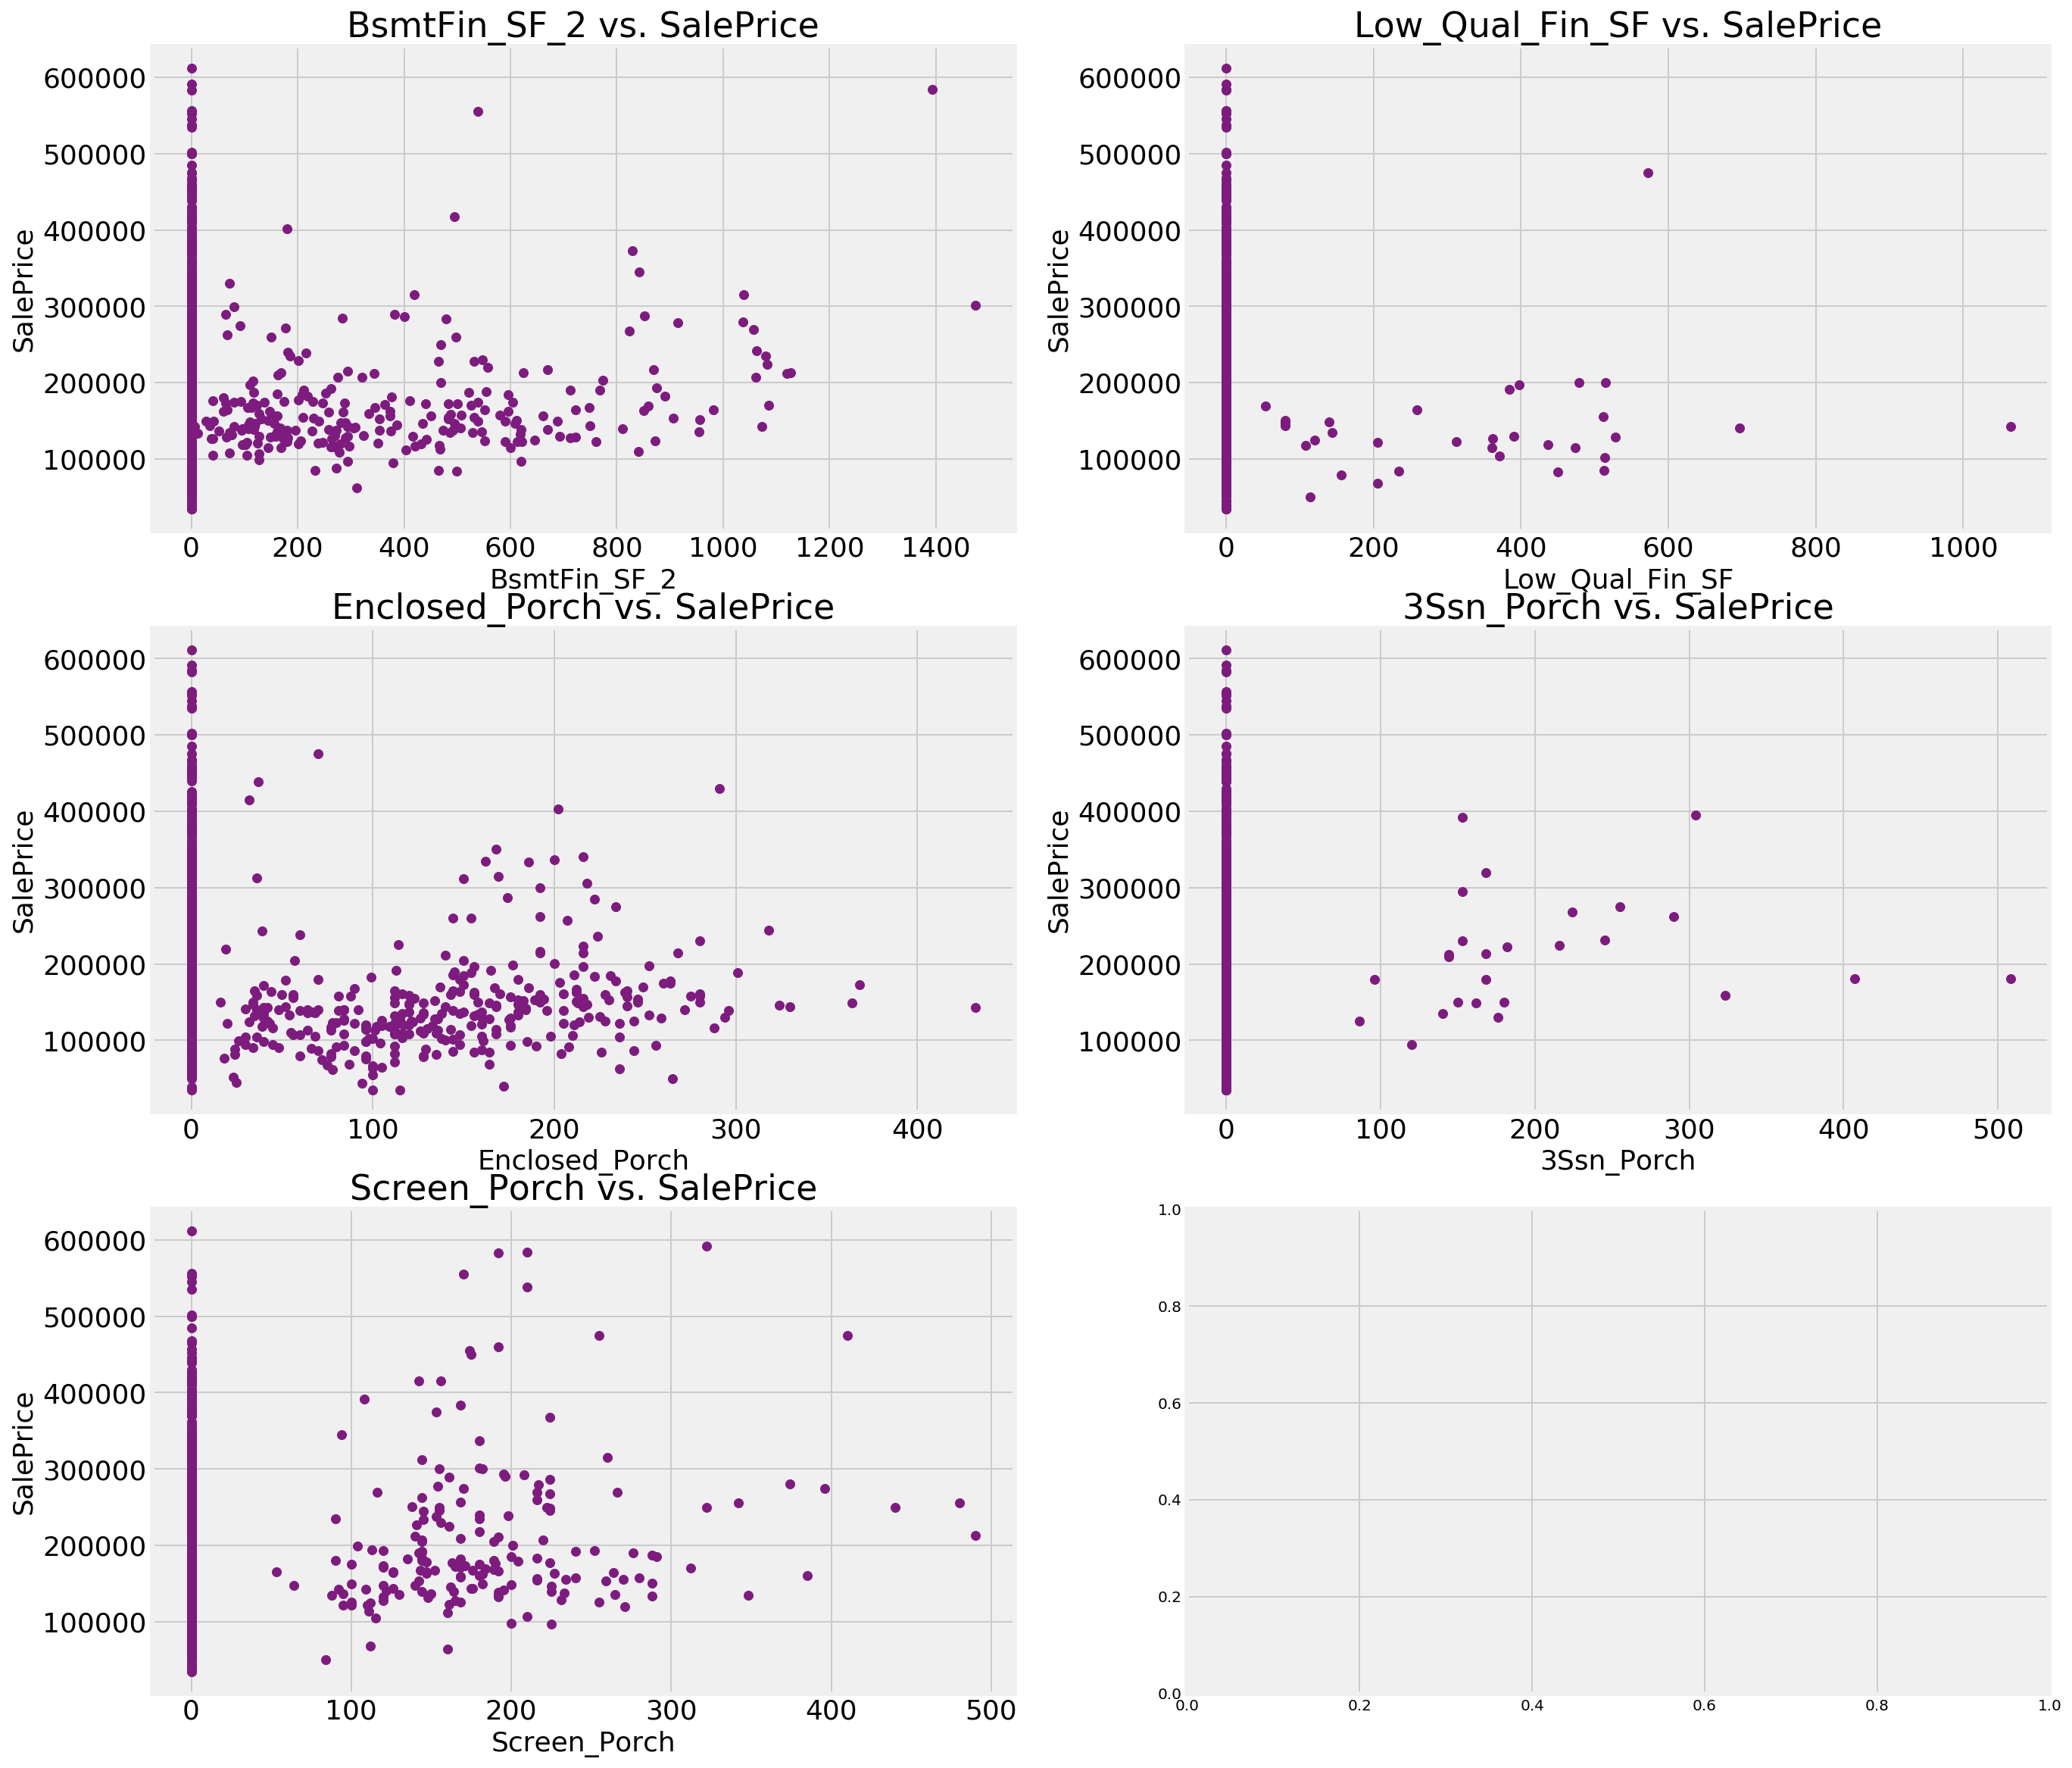

In [16]:
subplot_scatter(train_df, majority_zeroes, 'SalePrice', figsize_height = 20)

The scatterplots above are predictor variables that have at least 80% of their values be nulls. The lack of spread of values may prevent the predictor variables from having any meaningful coefficients in the upcoming regression models.

## Boxplots

Based on the scatterplots, there are some datapoints that have outliers. In order to view the spread in variables and differences in the interquartile range, I will create boxplots to elucidate a few outliers that might need to be fixed to prevent unnecessary noise.

#### Ordinal Numerical Predictor Variables

In [17]:
def subplot_boxplot(dataframe, list_of_columns, y_val, figsize_height = 80):
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
        fig, ax = plt.subplots(figsize=(20,figsize_height),nrows=nrows, ncols=2) # You'll want to specify your figsize
        ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
        for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
            ax[i].boxplot(dataframe[column])
            ax[i].set_title(f'{list_of_columns[i]} vs. {y_val}', fontsize = 23)
            ax[i].set_ylabel('values', fontsize = 18)
            ax[i].set_xlabel(list_of_columns[i], fontsize = 18)
            ax[i].tick_params(axis='x',labelsize=18)
            ax[i].tick_params(axis='y',labelsize=18)

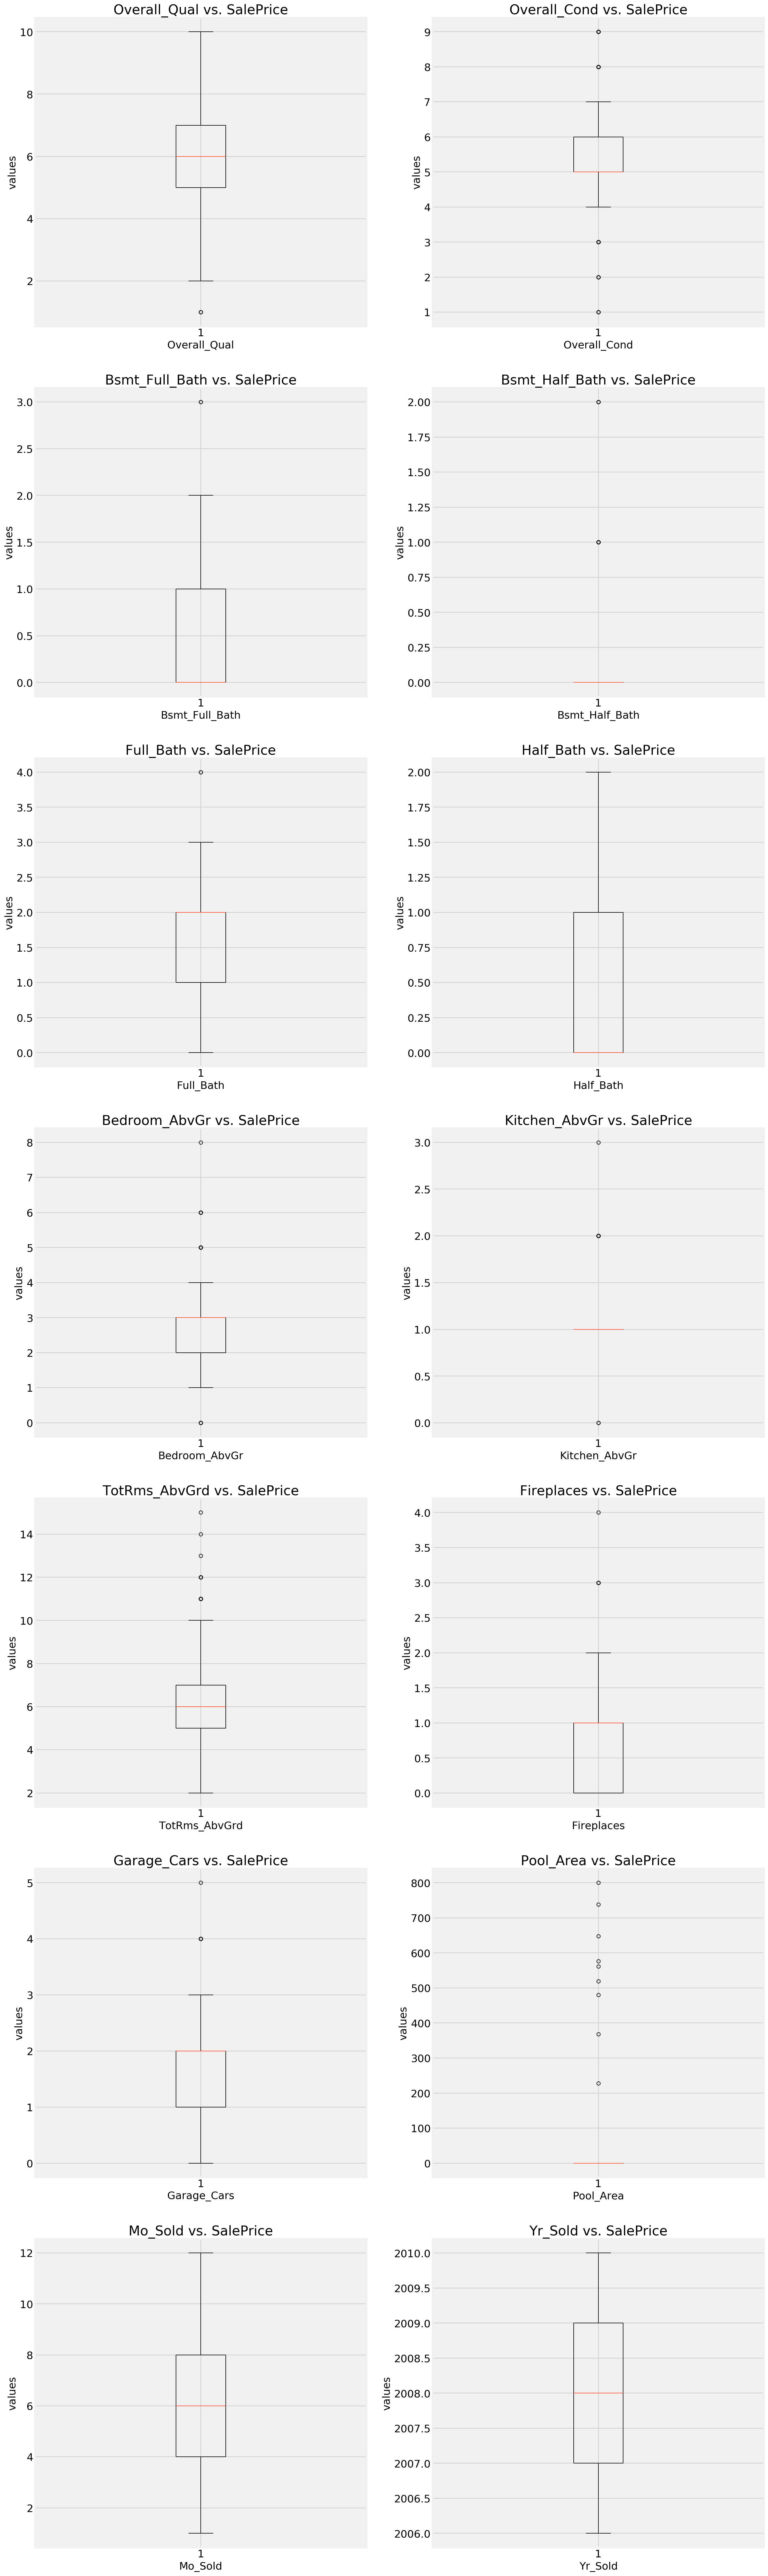

In [18]:
subplot_boxplot(train_df, discrete_cols, 'SalePrice')

#### Non Ordinal Numerical Predictor Variables

## Categorical Predictor Variables

I am now going to plot bar plots and look at the categorical variables and their count of values. I am first going to split the object variables into two. One for data that is organized by ratings, and the other for data that is categorical and organized by the features of a house.

In [19]:
train_df.dtypes.value_counts()

object     43
int64      24
float64    10
dtype: int64

In [20]:
object_cols = list(train_df.select_dtypes('object').columns)

In [21]:
rating_cols = []

for cols in object_cols:
    if 'Gd' in list(train_df[cols].unique()):
        rating_cols.append(cols)
    elif 'GdPrv' in list(train_df[cols].unique()):
        rating_cols.append(cols)        
    elif 'ALQ' in list(train_df[cols].unique()):
        rating_cols.append(cols)

rating_cols

['Exter_Qual',
 'Exter_Cond',
 'Bsmt_Qual',
 'Bsmt_Cond',
 'Bsmt_Exposure',
 'BsmtFin_Type_1',
 'BsmtFin_Type_2',
 'Heating_QC',
 'Kitchen_Qual',
 'Fireplace_Qu',
 'Garage_Qual',
 'Garage_Cond',
 'Pool_QC',
 'Fence']

In [22]:
not_in_both = set(object_cols).symmetric_difference(rating_cols)
house_feature_cols = list(not_in_both)

In [23]:
def subplot_bar(dataframe, list_of_columns, figsize_height = 180):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=(20,figsize_height),nrows=nrows, ncols=2) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].bar(list(dataframe[column].unique()),dataframe[column].value_counts().sort_values(), color= DO)
        ax[i].set_title(f'{list_of_columns[i]}', fontsize = 23)
        ax[i].set_xlabel('Count', fontsize = 18)
        ax[i].set_ylabel(list_of_columns[i], fontsize = 18)
        ax[i].tick_params(axis='x',labelsize=18)
        ax[i].tick_params(axis='y',labelsize=18)

### House Feature Categorical  Predictor Variables

In [24]:
subplot_bar(train_df, house_feature_cols)

**Observations**

There are many categorical house feature variables in which most of the observed data points fall under one category. This may be problematic as the data appears to be skewed based on the maximum unique value count.

### Ratings Predictor Variables

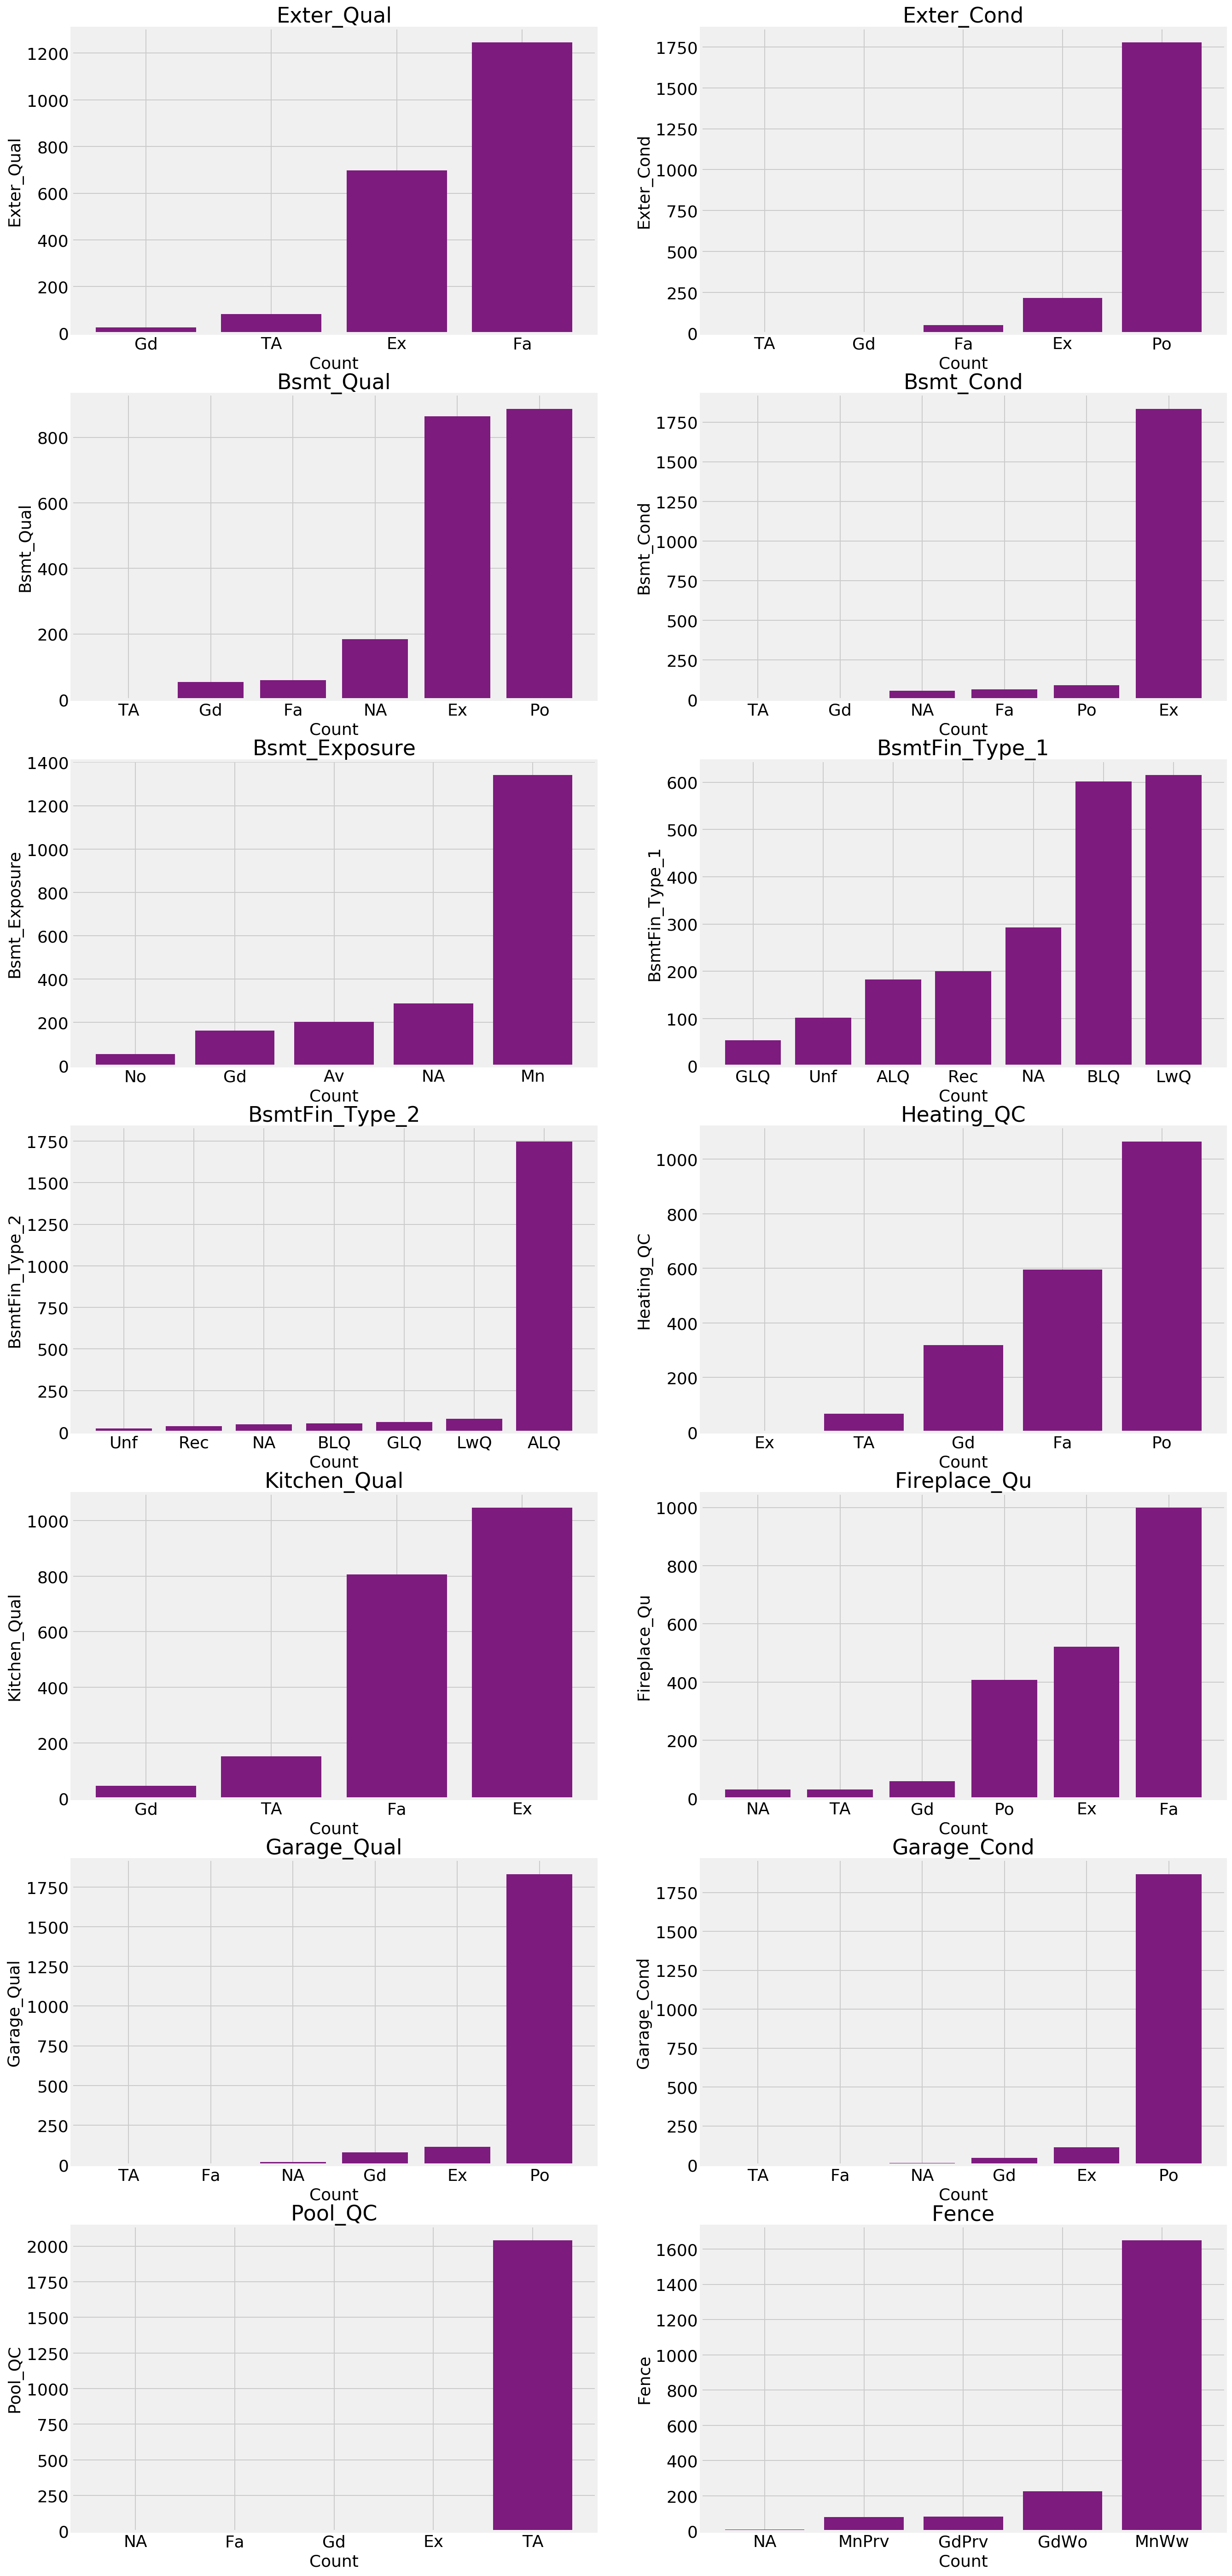

In [25]:
subplot_bar(train_df, rating_cols, figsize_height = 50)

**Observations**

Likewise, there are many rating variables in which most of the observed data points fall under one category. This may be problematic as the data might be skewed.

Though there are many variables that I suspect will have no regression effects on the SalePrice, I will eliminate the variables after I utilize different models.

## Normality Issue

I will now look at the continuous predictor variables and examine if they follow normality by using histograms as well as using a normality_test() function. 

In [26]:
def subplot_hist(dataframe, list_of_columns, figsize_height = 80):
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
        fig, ax = plt.subplots(figsize=(20,figsize_height),nrows=nrows, ncols=2) # You'll want to specify your figsize
        ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
        for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
            ax[i].hist(dataframe[column],color= DO)
            ax[i].set_title(f'{list_of_columns[i]}', fontsize = 23)
            ax[i].set_ylabel('Frequency', fontsize = 18)
            ax[i].set_xlabel(list_of_columns[i], fontsize = 18)
            ax[i].tick_params(axis='x',labelsize=18)
            ax[i].tick_params(axis='y',labelsize=18)

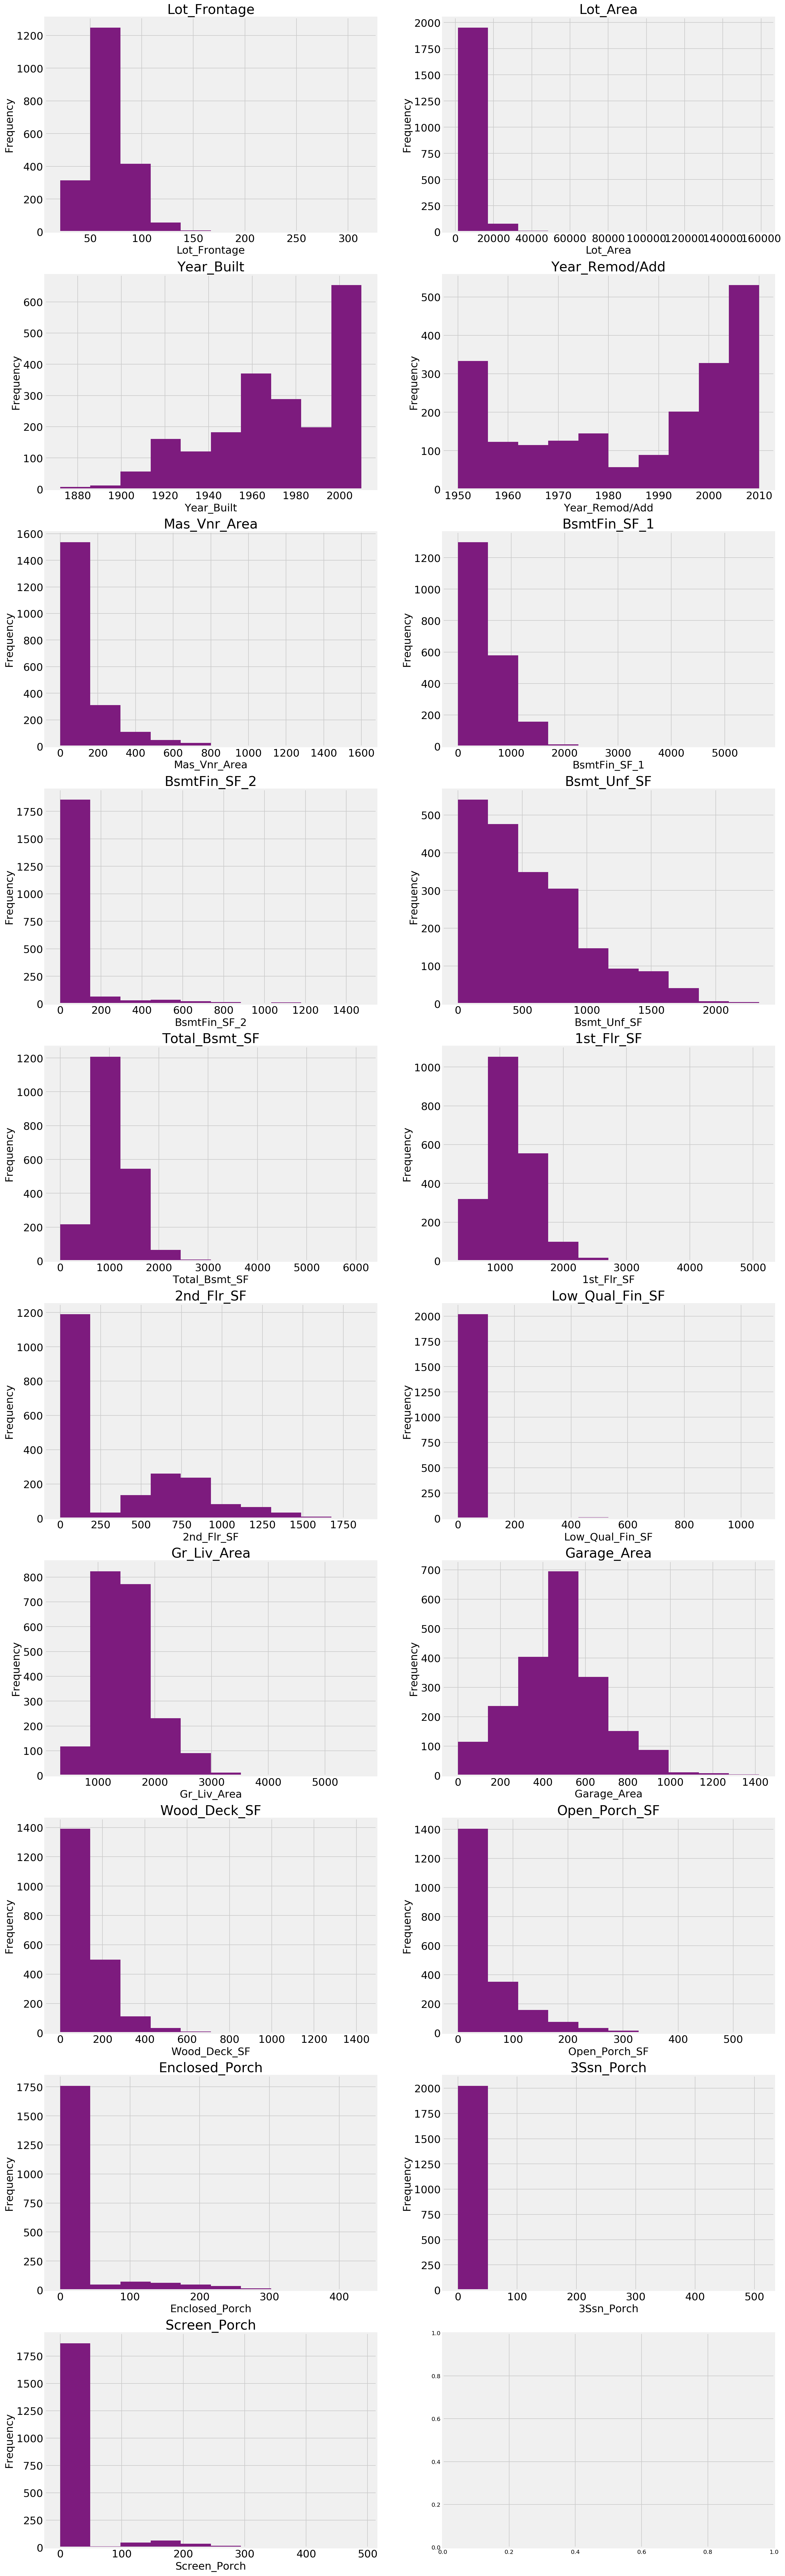

In [27]:
subplot_hist(train_df, cont_cols, figsize_height = 80)

The histograms indicate that the majority of the variables have a positive skew. The reason for the positive skew is due to the fact that many houses do not have those housing features, such as `Screen_Porch` and `Low_Qual_Fin_SF`.

The `normality_test2()` function compares the variable's 2-sided chi squared probability for the hypothesis test and compares it to the significance level of 0.05. If the p-value is less than the significance level, we can reject the null hypothesis that the variable follows normal distribution.

In [28]:
def normality_test(dataframe, list_of_cols ,sig_level=0.05):
    
    total_variables = len(list_of_cols)
    not_normal_variables = 0
    for col in list_of_cols:
        p_val = stats.normaltest(dataframe[col])[1]
        sig_lvl = 0.05
        if p_val < sig_lvl:
            #print(f'{col}')
            #print(f'P-Val: {p_val}\nSignificance Level: {sig_lvl}\n')
            #print("Since the p-value is less than the significance level, reject the null hypothesis and conclude that the data does not follow normal distribution.\n")
            not_normal_variables += 1
        elif p_val > sig_lvl:
            print(f'{col}')
            print(f'P-Val: {p_val}\nSignificance Level: {sig_lvl}\n')
            print("Since the p-value is greater than the significance level, we fail to reject the null hypothesis.\n")
    
    if not_normal_variables/total_variables == 1:
        print('For each variable, since the p-value is less than the significance level, reject the null hypothesis and conclude that the variable does not follow normal distribution.')
    else:
        print(f'{not_normal_variables} variables do not follow normal distribution')


In [29]:
normality_test(train_df, numerical_cols, sig_level = 0.05)

For each variable, since the p-value is less than the significance level, reject the null hypothesis and conclude that the variable does not follow normal distribution.


All 35 numerical predictor variables do not follow normality. Furthermore, there are vastly different units for the predictor variables. In order to mitigate this issue, it will be appropriate to use a standard scaler to normalize all the variables' distributions.

## Sale Price Normality

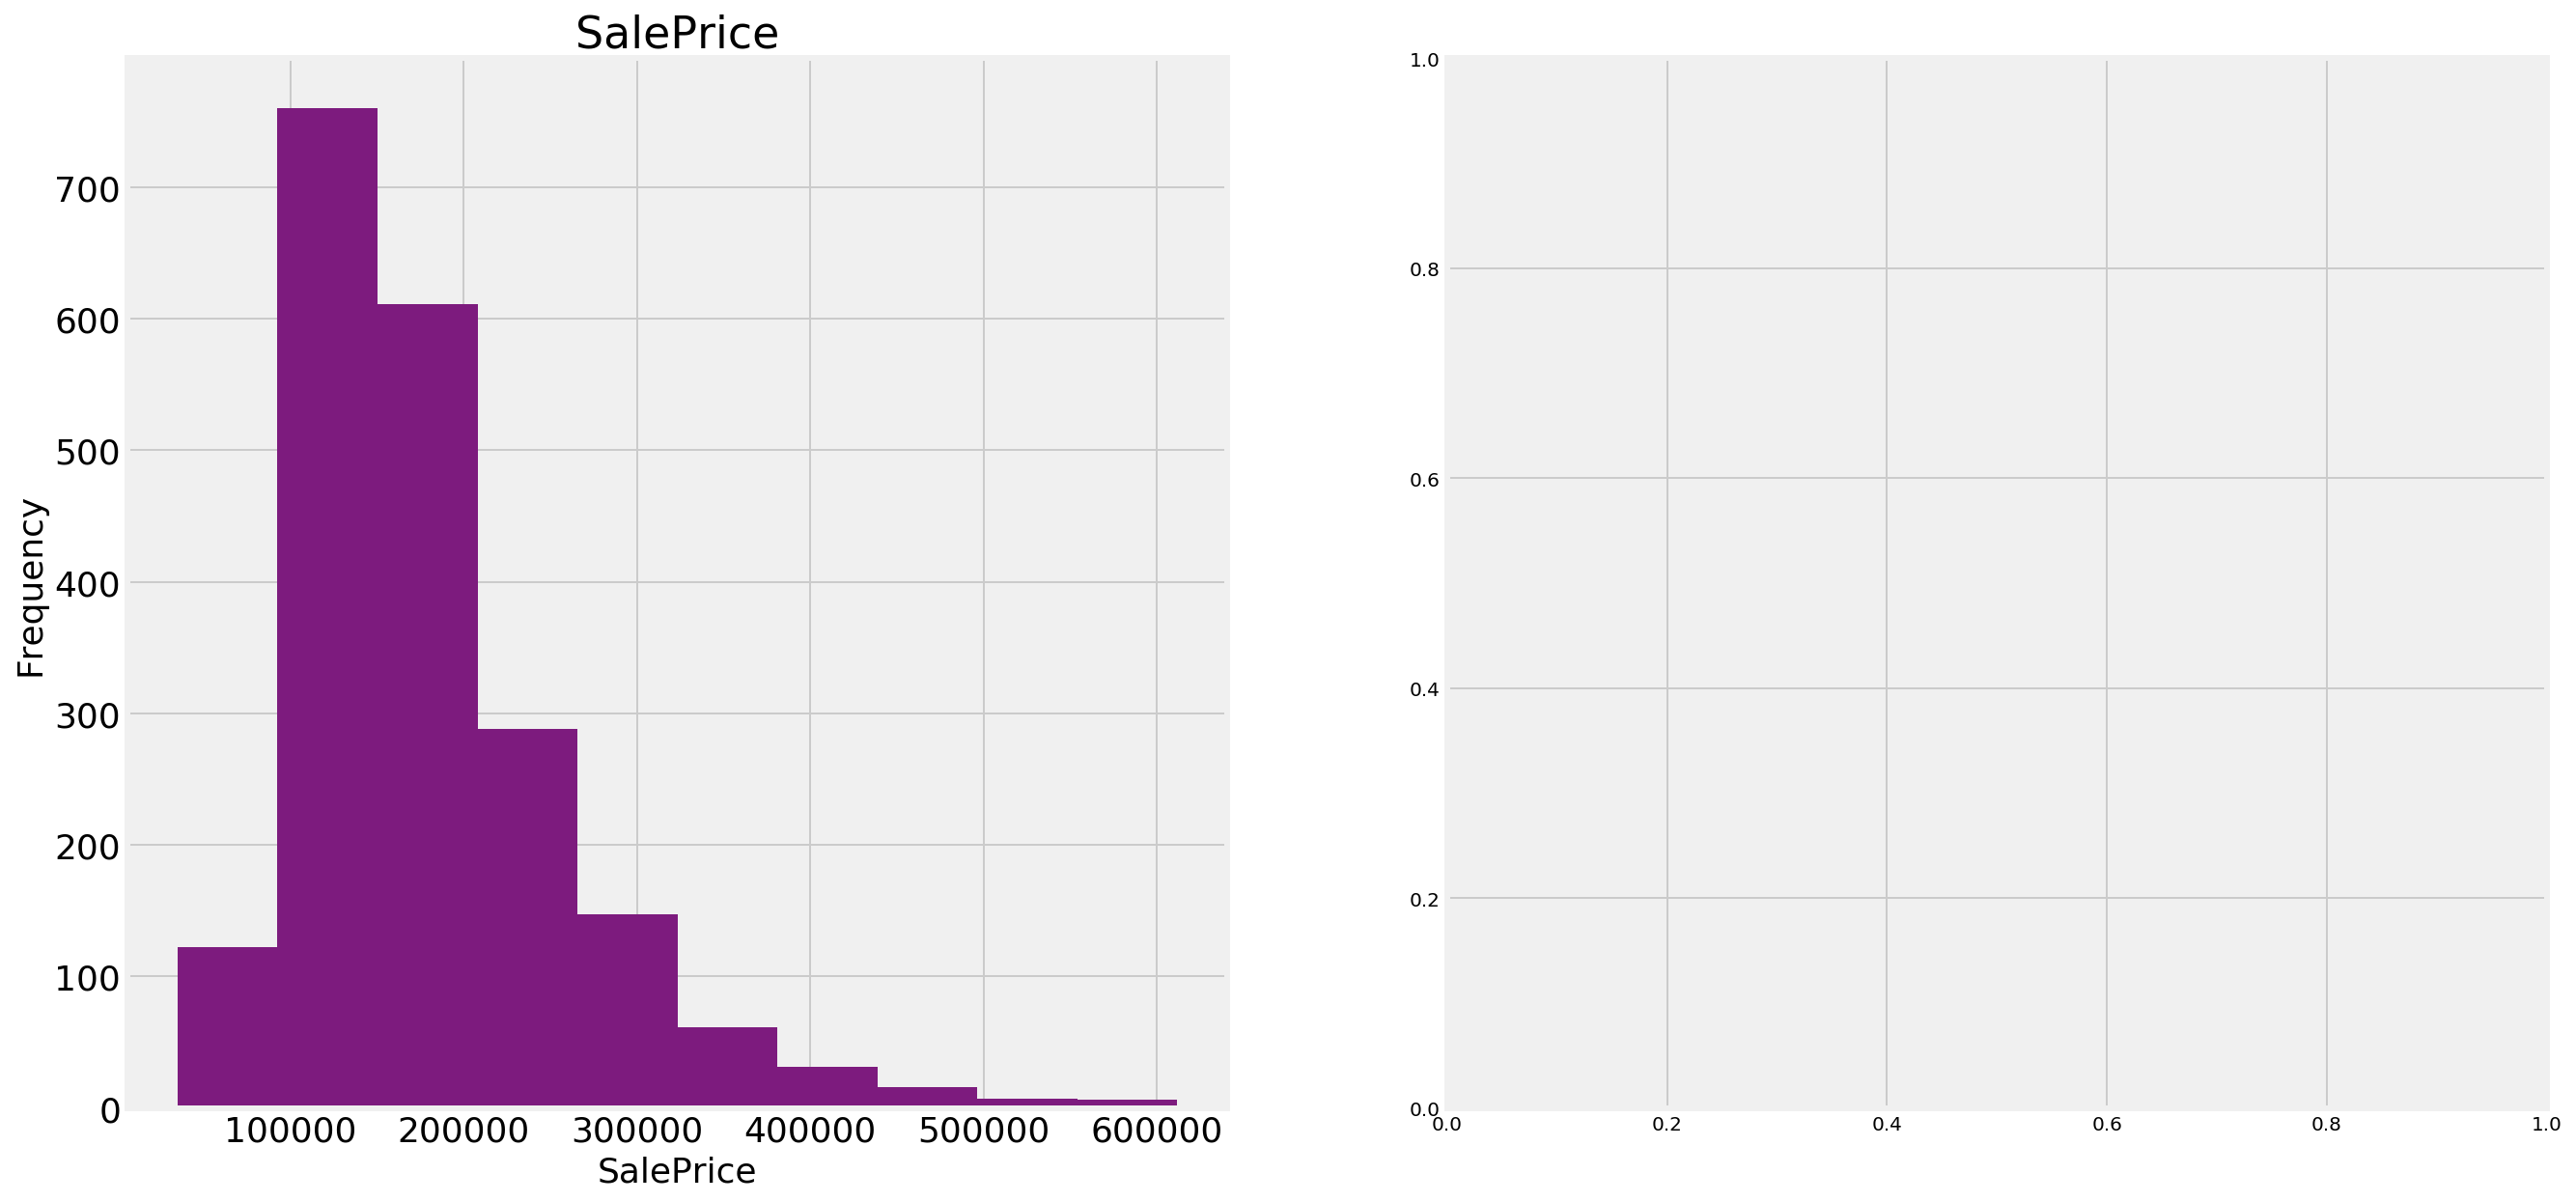

In [30]:
subplot_hist(train_df, ['SalePrice'], figsize_height = 10)

In [31]:
sp_median = train_df['SalePrice'].median()
sp_mean = train_df['SalePrice'].mean()

In [32]:
print(f'Sale Price median: {sp_median}')
print(f'Sale Price mean: {sp_mean}')

Sale Price median: 162500.0
Sale Price mean: 181634.19668130795


It appears that the dependent variable, Sale Price, is not normally distributed as it has a positive skew. This means the outliers on the right, such as houses that cost \\$500,000 to \\$600,000 will cause the mean to shift upwards. However, the majority of the houses fall between \\$100,000 to \\$200,000 which will help with predictions. 

In [33]:
train_df.to_csv('../datasets/train_clean_EDA.csv', index = False)

# Please go to Part 3: Multiple Linear Model